In [2]:
# Adding DySMHO repositories to the environment
import sys
# Insert path to directory here
path_to_dysmho = ''
sys.path.insert(0, path_to_dysmho+'model')
sys.path.insert(0, path_to_dysmho+'data')

# Loading functions and packages
import model_2D
import utils
import LV_data_generation
import numpy as np
from importlib import reload
import matplotlib.pyplot as plt
import pandas as pd

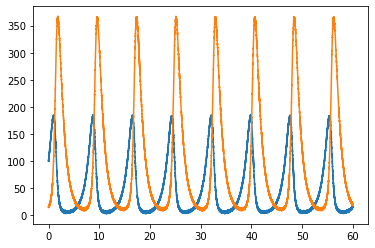



--------------------------- Smoothing data ---------------------------


Prev STD: 0.00775 - New STD: 0.00155 - Percent change: -80.06619
Prev STD: 0.00155 - New STD: 0.00100 - Percent change: -35.03416
Prev STD: 0.00100 - New STD: 0.00088 - Percent change: -12.07941
Prev STD: 0.00088 - New STD: 0.00084 - Percent change: -4.93032
Smoothing window size (dimension 1): 31 

Prev STD: 0.00401 - New STD: 0.00105 - Percent change: -73.85289
Prev STD: 0.00105 - New STD: 0.00086 - Percent change: -17.52090
Prev STD: 0.00086 - New STD: 0.00083 - Percent change: -4.02979
Smoothing window size (dimension 2): 21 



C:\Users\fl6344\Anaconda3\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\fl6344\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:2007: RuntimeWarning: overflow encountered in true_divide
  s = divide(1, s, where=large, out=s)




--------------------------- Pre-processing 1: Dimension 1 ---------------------------
                  0             1
y0         0.000000  0.000000e+00
y1         0.000000  0.000000e+00
y0*y1      0.000000  0.000000e+00
y0^2       0.114222  1.272445e-05
y1^2       0.000000  0.000000e+00
(y0^2)*y1  0.000000  0.000000e+00
y0*(y1^2)  0.000000  0.000000e+00
 y0^3      0.075961  1.088880e-05
y0^4       0.107622  1.245391e-05
exp(y0)    0.750000  4.330127e-01
1/y0       0.000214  2.202220e-07
sin(y0)    0.321660  1.517115e-05
cos(y0)    0.691301  8.638990e-06
dy_dt      0.000000  0.000000e+00
y_shift    0.749997  4.330109e-01 

Columns to keep for y1:  ['1', 'y0', 'y1', 'y0*y1', 'y1^2', '(y0^2)*y1', 'y0*(y1^2)', ' y0^3', '1/y0']


--------------------------- Pre-processing 2: Dimension 2 ---------------------------
                  0         1
y0         0.000000  0.000000
y1         0.000000  0.000000
y0*y1      0.000000  0.000000
y0^2       0.000000  0.000000
y1^2       0.027301  0.00

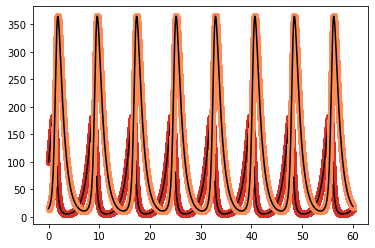

In [10]:
# Define initial conditions for the 2 states 
y_init = [100, 15]

# Horizon length for optimization problem (arbitrary time units) 
horizon_length = 20  

# Number of sampling time periods taken per MHE step
time_steps = 40  

# Basis functions for dynamics of state 1 
basis_functions_y0 = [lambda y0,y1: 1, 
                  lambda y0, y1: y0,
                  lambda y0, y1: y1, 
                  lambda y0, y1: y0*y1,
                  lambda y0, y1: y0**2,
                  lambda y0, y1: y1**2,
                  lambda y0, y1: (y0**2)*y1,
                  lambda y0, y1: y0*(y1**2),
                  lambda y0, y1: y0**3,
                  lambda y0, y1: y0**4,
                  lambda y0, y1: np.exp(y0), 
                  lambda y0, y1: 1/y0, 
                  lambda y0, y1: np.sin(y0),
                  lambda y0, y1: np.cos(y0)]

# Basis functions for dynamics of state 2
basis_functions_y1 = [lambda y0,y1: 1, 
                  lambda y0, y1: y0,
                  lambda y0, y1: y1, 
                  lambda y0, y1: y0*y1,
                  lambda y0, y1: y0**2,
                  lambda y0, y1: y1**2,
                  lambda y0, y1: (y0**2)*y1,
                  lambda y0, y1: y0*(y1**2),
                  lambda y0, y1: y1**3,
                  lambda y0, y1: y1**4,
                  lambda y0, y1: np.exp(y1), 
                  lambda y0, y1: 1/y1, 
                  lambda y0, y1: np.sin(y1),
                  lambda y0, y1: np.cos(y1)]
# Basis function names
basis_functions_names_y0 = ['1','y0', 'y1', 'y0*y1', 'y0^2', 'y1^2', '(y0^2)*y1', 'y0*(y1^2)', ' y0^3',  'y0^4', 'exp(y0)', '1/y0', 'sin(y0)', 'cos(y0)']
basis_functions_names_y1 = ['1','y0', 'y1', 'y0*y1', 'y0^2', 'y1^2', '(y0^2)*y1', 'y0*(y1^2)', ' y1^3',  'y1^4', 'exp(y1)', '1/y1', 'sin(y1)', 'cos(y1)']
basis_y0 = {'functions': basis_functions_y0, 'names': basis_functions_names_y0} 
basis_y1 = {'functions': basis_functions_y1, 'names': basis_functions_names_y1}


# Data generation (time grid)
xs = np.linspace(0, horizon_length + time_steps, 500 * (horizon_length + time_steps) + 1)
# Data generation (simulating true dynamics on the time grid with addition of white noise )
t, y = LV_data_generation.data_gen(xs, [y_init[0], y_init[1]], [0, 1, 0, 1], False)
# Data generation (simulating true dynamics on the time grid without addition of white noise)
t_nf, y_nf = LV_data_generation.data_gen(xs, [y_init[0], y_init[1]], [0, 0, 0, 0], False)

# Visualizing simulated data
plt.plot(t,y)
plt.show()


# Creating MHL class
LV_example = model_2D.DySMHO(y,t, [basis_y0, basis_y1])
# Applying SV smoothing 
LV_example.smooth()
# Pre-processing 1: generates features and tests for Granger Causality 
LV_example.pre_processing_1()
# Pre-processing 2: uses OLS for initialization and for bounding parameters
LV_example.pre_processing_2(significance = 0.8)
# Calling for main discovery task
LV_example.discover(horizon_length, 
                    time_steps, 
                    data_step = 100, 
                    optim_options = {'nfe': 50, 'ncp':5}, 
                    thresholding_frequency = 10, 
                    thresholding_tolerance = 1, 
                    sign = True)
# Validation of discovered equations
LV_example.validate(xs, y_nf, plot = True)
